In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(16)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 16


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Real Beam Params
L_real = 5.0      # Beam length (m)
W_real = 1.0      # Beam width (m)
H_real = 1.0      # Beam height (m)

# 3D problems use fundamental material properties E and nu, not the composite EI.
# We can derive E from your old EI value for consistency.
# For a rectangular cross-section, I = (width * height^3) / 12

EI_real = 135245
I = (W_real * H_real**3) / 12.0  # Moment of Inertia
E_real = EI_real / I             # E = EI / I -> 135245 / (1/12) = 1,622,940 Pa
nu_real = 0.3                    # Poisson's Ratio (a material property, 0.3 is common)

# Force magnitudes remain the same
P_tip_real = 500  # N
P_mid_real = 300  # N

# Normalisation
L_characteristic = L_real

L_norm = L_real / L_characteristic # = 1.0
W_norm = W_real / L_characteristic # = 0.2
H_norm = H_real / L_characteristic # = 0.2
P_characteristic = P_tip_real

P_tip_norm = P_tip_real / P_characteristic
P_mid_norm = P_mid_real / P_characteristic

E_norm = E_real / (P_characteristic / L_real**2)
nu_norm = nu_real

x_scale = L_real
w_scale = (P_characteristic * L_real**3) / EI_real

# Define Neural Network
class PINN_Cantilever(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            #nn.Linear(64, 64),
            #nn.Tanh(),
            #nn.Linear(64, 64),
            #nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.net(x)

In [3]:
# 3d problem only requires first derivative
def get_gradient(y, x):
    """Computes the gradient of y (N, 3) with respect to x (N, 3)."""
    # We need to compute the gradient of each output component (u, v, w) separately
    grad_u = torch.autograd.grad(y[:, 0], x, grad_outputs=torch.ones_like(y[:, 0]), create_graph=True)[0]
    grad_v = torch.autograd.grad(y[:, 1], x, grad_outputs=torch.ones_like(y[:, 1]), create_graph=True)[0]
    grad_w = torch.autograd.grad(y[:, 2], x, grad_outputs=torch.ones_like(y[:, 2]), create_graph=True)[0]
    
    # Stack them to form the full gradient tensor of shape [N, 3, 3]
    # where grad[i, j, k] = d(u_j)/d(x_k) for the i-th point
    return torch.stack([grad_u, grad_v, grad_w], dim=1)

# Loss Function
def loss_fn_energy(model, x_interior, x_forces, P_forces, x_boundary, E, nu):
#====================================================================================
    # 1. Strain Energy (U) - Energy stored in the bent beam
#====================================================================================

    x_interior.requires_grad = True
    u_interior = model(x_interior)

    # Calculate the 3x3 displacement gradient tensor (du/dx)
    grad_u = get_gradient(u_interior, x_interior) # Shape: [N, 3, 3]

    # Calculate the 6 unique components of the symmetric strain tensor (ε = 0.5 * (∇u + (∇u)^T))
    epsilon_xx = grad_u[:, 0, 0]
    epsilon_yy = grad_u[:, 1, 1]
         # e.g. ^ "for all N point indices, y component of displacement (v), derivative wrt y"
    epsilon_zz = grad_u[:, 2, 2]
    epsilon_xy = 0.5 * (grad_u[:, 0, 1] + grad_u[:, 1, 0])
    epsilon_xz = 0.5 * (grad_u[:, 0, 2] + grad_u[:, 2, 0])
    epsilon_yz = 0.5 * (grad_u[:, 1, 2] + grad_u[:, 2, 1])

    #Calculate the 6 unique components of the stress tensor (σ) using Hooke's Law
    # First, calculate Lamé parameters from E and nu
    # -->> Lame params make the maths simpler (more simple than youngs mod E and poisson ratio nu)
    lmbda = (E * nu) / ((1 + nu) * (1 - 2 * nu))
    mu = E / (2 * (1 + nu))

    # Volumetric strain (calculated as the trace of the strain tensor)
    tr_epsilon = epsilon_xx + epsilon_yy + epsilon_zz

    sigma_xx = lmbda * tr_epsilon + 2 * mu * epsilon_xx
    sigma_yy = lmbda * tr_epsilon + 2 * mu * epsilon_yy
    sigma_zz = lmbda * tr_epsilon + 2 * mu * epsilon_zz
    sigma_xy = 2 * mu * epsilon_xy
    sigma_xz = 2 * mu * epsilon_xz
    sigma_yz = 2 * mu * epsilon_yz

    # Calculate strain energy density (uses the stress tensor, σ)
    #------------------------------------------------------------------

    #SED = 0.5 * (σ : ε), : is the double dot product
    strain_energy_density = 0.5 * (
        sigma_xx * epsilon_xx + sigma_yy * epsilon_yy + sigma_zz * epsilon_zz +
        2 * (sigma_xy * epsilon_xy + sigma_xz * epsilon_xz + sigma_yz * epsilon_yz)
    )

    #Total Strain Energy (U) is the integral (mean) of the density over the volume
    # Assuming the volume of the domain is V = L*W*H. For a 2x1x1 beam, V=2.
    # If using a normalized domain of 1x1x1, V=1.
    domain_volume = L_real * H_real * W_real 
    strain_energy = torch.mean(strain_energy_density) * domain_volume

    #=======================================================================================
    #=======================================================================================

    # 2. Work Potential (W) - Work done by external forces
    u_at_forces = model(x_forces)  #[num_forces, 3]
    # -->> Sum of dot products: Σ (P_i · u_i)
    work_potential = torch.sum(P_forces * u_at_forces)

    # 3. Boundary Conditions (BCs) at the fixed wall
    u_boundary = model(x_boundary)
    loss_displacement = torch.mean(u_boundary.pow(2))

    grad_u_boundary = get_gradient(u_boundary, x_boundary)
    loss_slope = torch.mean(grad_u_boundary.pow(2))

    loss_bc = loss_displacement + loss_slope

    # 4. Total Loss
    # The total loss is the potential energy of the system plus the BC penalty.
    return strain_energy - work_potential + 5e4 * loss_bc

In [4]:
# Initialize
model = PINN_Cantilever()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



# Training Data (normalized domain)

num_interior_points = 5000
x_interior = torch.rand(num_interior_points, 3)
x_interior *= torch.tensor([L_norm, W_norm, H_norm])
x_interior.requires_grad = True

x_forces = torch.tensor([
    [1.0, 0.5, 0.5], # Midpoint force location
    [2.0, 0.5, 0.5]  # Tip force location
])
P_forces = torch.tensor([
    [0.0, 0.0, -500.0], # Midpoint force vector
    [0.0, 0.0, -500.0]  # Tip force vector
])

# Boundary Points 
num_boundary_points = 1000
x_boundary = torch.rand(num_boundary_points, 3)
x_boundary[:, 0] = 0.0 # Set x-coordinate to 0
x_boundary[:, 1] *= W_norm
x_boundary[:, 2] *= H_norm
x_boundary.requires_grad = True

# Force Tensors
x_forces = torch.tensor([
    [L_norm / 2, W_norm / 2, H_norm / 2], # Midpoint force location
    [L_norm, W_norm / 2, H_norm / 2]
])

P_forces = torch.tensor([
    [0.0, 0.0, -P_mid_norm], # Midpoint force vector
    [0.0, 0.0, -P_tip_norm]  # Tip force vector
])

# Training Loop
for epoch in range(1000):
    optimizer.zero_grad()
    loss = loss_fn_energy(model, x_interior, x_forces, P_forces, x_boundary, E_norm, nu_norm)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.6f}")



Epoch 0, Loss = 917.690430
Epoch 100, Loss = 0.082367
Epoch 200, Loss = 0.019267
Epoch 300, Loss = 0.014879


KeyboardInterrupt: 

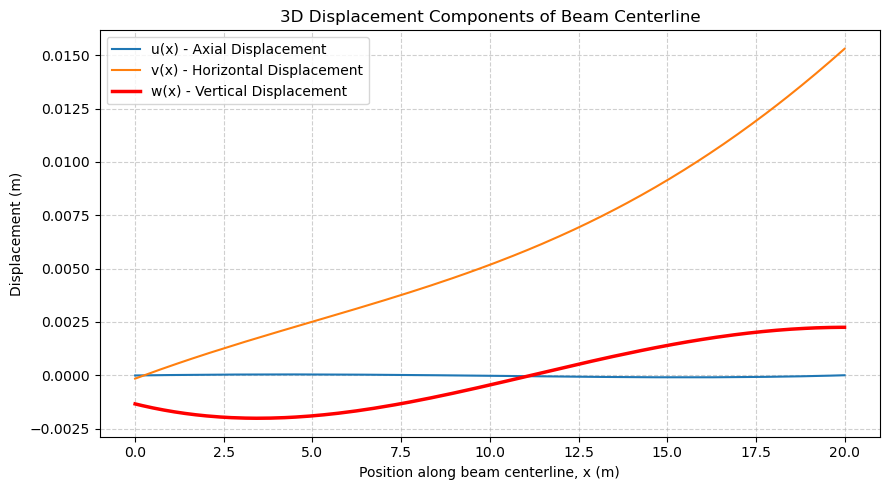

In [5]:
# --- Evaluation and Plotting ---

# 1. Create 3D points along the beam's centerline for evaluation
# We create a line where y and z are at the center of the cross-section.
x_coords_norm = torch.linspace(0, L_norm, 200).view(-1, 1)
y_coords_norm = torch.full_like(x_coords_norm, W_norm / 2)
z_coords_norm = torch.full_like(x_coords_norm, H_norm / 2)
x_eval_3d_norm = torch.cat([x_coords_norm, y_coords_norm, z_coords_norm], dim=1)

# 2. Get the 3D displacement prediction from the model
# The model now outputs a tensor of shape [200, 3] for (u,v,w).
with torch.no_grad():
    displacement_pred_norm = model(x_eval_3d_norm).numpy()

# 3. Un-scale the results to real units for plotting
x_vals_real = x_coords_norm.numpy() * x_scale
# The w_scale applies to all displacement components (u, v, and w).
u_pred_real = displacement_pred_norm[:, 0] * w_scale # First column is u
v_pred_real = displacement_pred_norm[:, 1] * w_scale # Second column is v
w_pred_real = displacement_pred_norm[:, 2] * w_scale # Third column is w

# 4. Plot each displacement component on the same graph
plt.figure(figsize=(9, 5))
plt.plot(x_vals_real, u_pred_real, label="u(x) - Axial Displacement")
plt.plot(x_vals_real, v_pred_real, label="v(x) - Horizontal Displacement")
plt.plot(x_vals_real, w_pred_real, label="w(x) - Vertical Displacement", linewidth=2.5, color='red')

plt.xlabel("Position along beam centerline, x (m)")
plt.ylabel("Displacement (m)")
plt.title("3D Displacement Components of Beam Centerline")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()